In [116]:
"""Test"""
#importing the libraries
import numpy as np 
import torch
import matplotlib.pyplot as plt
import os

In [117]:
def load_train_data():
  results_path = f"results/imputed_data/traffic"
  file_name = f"numuser_20_L_100_dim_70_missingPercentage_20.npy"
  file_path = os.path.join(results_path, file_name)
  return_file = np.load(file_path)
  return return_file

In [118]:
def load_test_data():
  results_path = f"results/test_data"
  file_name = f"test_traff_data_168steps.npy"
  file_path = os.path.join(results_path, file_name)
  return_file = np.load(file_path)
  return return_file

In [119]:
from torch.utils.data import Dataset
import torch
# Create dataset
class timeseries(Dataset):
  def __init__(self, x, y):
    self.x = torch.Tensor(x)
    self.y = torch.Tensor(y)
    self.len = x.shape[0]
    # print(self.len)
  def __getitem__(self, idx):
    return self.x[idx], self.y[idx] 
  
  def __len__(self):
    return self.len

In [120]:
%cd 
%cd phD/semester3/FedMSSA/FedSSA-mSSA

/share/home/tung6100
/share/home/tung6100/phD/semester3/FedMSSA/FedSSA-mSSA


In [121]:
train_data = load_train_data()
train_data.shape

(20, 17300)

In [122]:
test_data = load_test_data()
test_data.shape

(20, 168)

In [123]:
# Define the test settings
window = 40
prediction_steps = 24
num_users = 20

In [124]:
# Get the last window of train data
last_window = train_data[:, -window:]

# Get actual data for prediction steps
actual_steps = test_data[:, -prediction_steps:]

last_window.shape, actual_steps.shape

((20, 40), (20, 24))

In [125]:
def create_np_data(user_test_data, prediction_steps=24):
    x_test = []
    y_test = []

    for i in range(prediction_steps):
        x_test.append(user_test_data[i:i+window])
        y_test.append(user_test_data[i+window])
    x_test = np.array(x_test)
    y_test = np.array(y_test)
    return x_test, y_test

In [126]:
def load_model(model_name):
    # model_path = "server.pt"
    model_path = os.path.join("models", "Imputed_Traff20", model_name + ".pt")
    assert (os.path.exists(model_path))
    model = torch.load(model_path)

    return model

In [127]:
model_name = f"FedLSTM_Imputed_Traff20_num_user_{num_users}_L_100_dim_70_MP_20_W40"
model = load_model(model_name=model_name)
model

LSTM_nn(
  (lstm): LSTM(1, 5, num_layers=3, batch_first=True)
  (fc1): Linear(in_features=5, out_features=1, bias=True)
)

In [128]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

/home/tung6100/.local/lib/python3.8/site-packages/torch/nn/modules/rnn.py:761: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  ../aten/src/ATen/native/cudnn/RNN.cpp:926.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


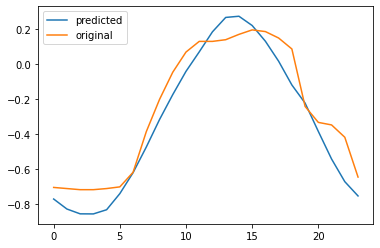

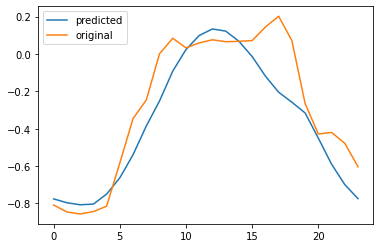

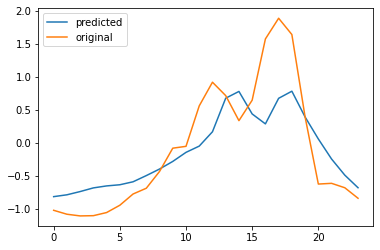

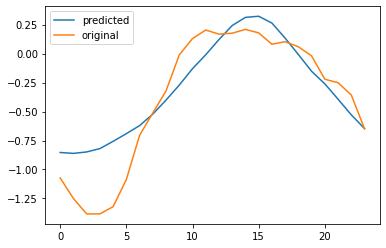

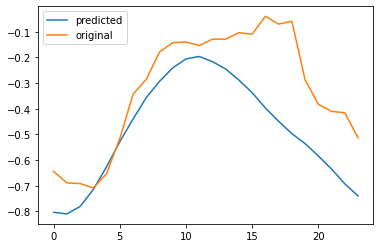

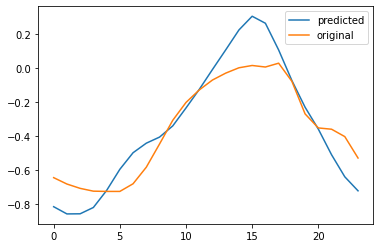

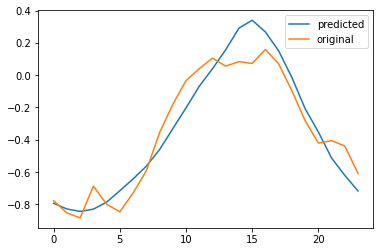

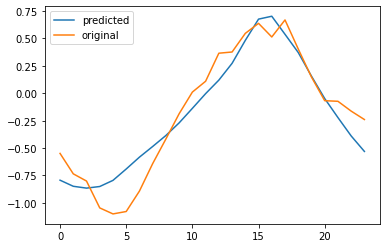

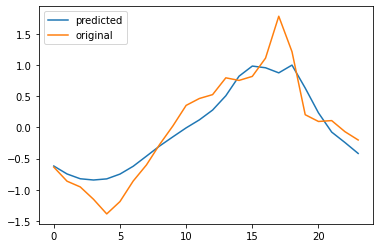

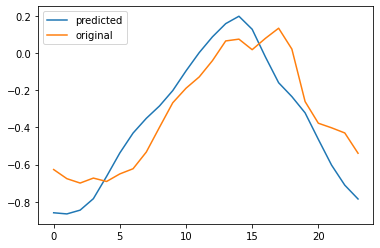

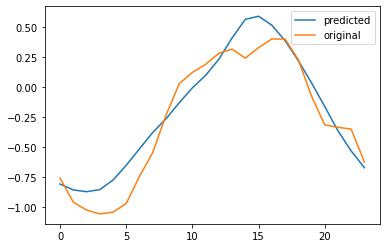

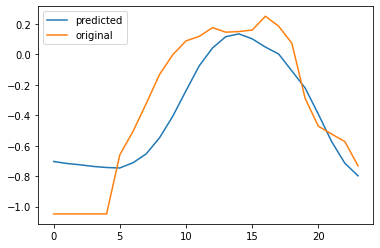

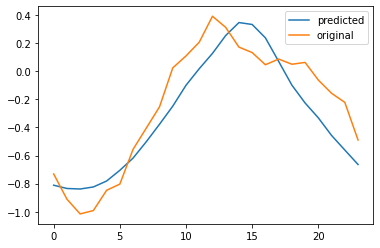

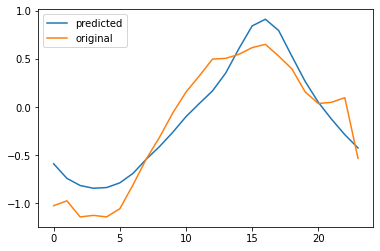

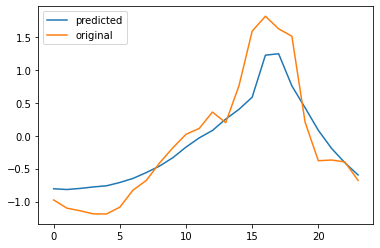

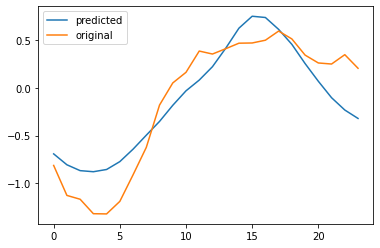

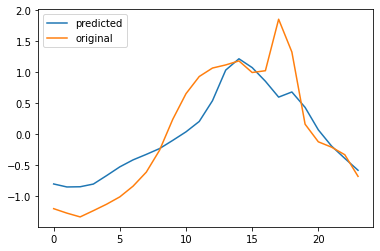

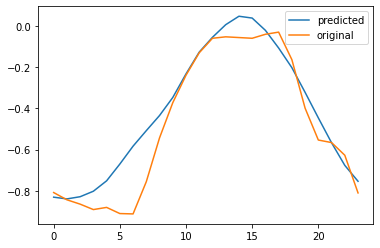

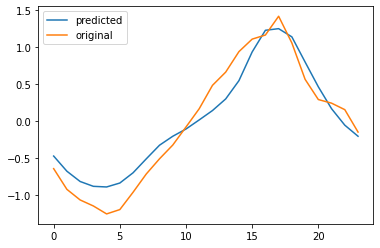

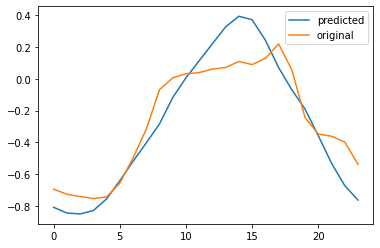

RMSE FedMSSA + LSTM: 0.2563996911048889


In [129]:
diff_list = []
y_pred = []
y_true = []
for user_id in range(num_users):
    user_last_window = last_window[user_id]
    user_actual_steps = actual_steps[user_id]
    user_test_data = np.concatenate((user_last_window, user_actual_steps), axis=None)
    # print(f"{user_last_window.shape}, {user_actual_steps.shape}, {user_test_data.shape}")

    """Create input data for data model"""
    # Create np data
    x_test, y_test = create_np_data(user_test_data=user_test_data, prediction_steps=prediction_steps)
    # Cretate dataset
    test_set = timeseries(x_test, y_test)
    # Prediction
    input = test_set[:][0].view(-1,window,1)
    actual = test_set[:][1].view(-1)
    input = input.to(device)
    test_pred = model(input).view(-1)
    predictions_24 = test_pred.cpu().detach().numpy()
    actual = actual.numpy()
    diff = predictions_24 - actual
    diff_list.append(diff)
    plt.plot(predictions_24, label='predicted')
    plt.plot(actual, label='original')
    plt.legend()
    plt.plot()
    plt.show()
    # break
    y_pred.append(predictions_24)
    y_true.append(actual)
diff_np = np.array(diff_list)
rmse = np.sqrt(np.mean(np.square(diff_np)))
print(f"RMSE FedMSSA + LSTM: {rmse}")

In [130]:
y_pred_np = np.array(y_pred)
y_true_np = np.array(y_true)

y_pred_np.shape, y_true_np.shape

((20, 24), (20, 24))

In [131]:
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
def evaluate_Testset(y_true, y_pred):
    def mape(y_true, y_pred): 
      return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    MSE = mse(y_true, y_pred)
    RMSE = np.sqrt(MSE)
    MAE = mae(y_true, y_pred)
    MAPE = mape(y_true, y_pred)
    return MSE, RMSE, MAE, MAPE

# Function to estimate accuracy for one user
def accuracy_Testset(y_true, y_pred):
  diff_pred = list()
  diff_true = list()
  accuracy = 0.
  for i in range(len(y_true)-1):
      diff_pred.append(y_pred[i+1]-y_pred[i])
      diff_true.append(y_true[i+1]-y_true[i])
  count = sum(diff_pred[i] * diff_true[i] > 0 for i in range(len(diff_pred)))
  accuracy = count/len(diff_pred) * 100
  return accuracy

# Function to estimate average accuracy for multiple users
def average_acc(y_true, y_pred):
    n_users = y_true.shape[0]
    acc_list = []
    for i in range(n_users):
        y_true_i = y_true[i]
        y_pred_i = y_pred[i]
        acc = accuracy_Testset(y_true_i, y_pred_i)
        acc_list.append(acc)
    acc_np = np.array(acc_list)
    # print(acc_np)
    avg_acc = np.mean(acc_np)
    return avg_acc

In [132]:
MSE, RMSE, MAE, MAPE = evaluate_Testset(y_true_np, y_pred_np)
avg_acc = average_acc(y_true_np, y_pred_np)
print(f"MSE: {MSE}, RMSE: {RMSE}, MAE: {MAE}, MAPE: {MAPE}")
print(f"Avg_Acc: {avg_acc}")

MSE: 0.06574079394340515, RMSE: 0.25639966130256653, MAE: 0.18946628272533417, MAPE: 198.26380014419556
Avg_Acc: 78.04347826086956
